In [4]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import loadmat
from scipy.signal import butter, lfilter
from scipy.fftpack import fft
from tqdm import tqdm

In [74]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def getBandRange(bandname):
    if bandname == "delta":  #TODO
        lowcut, highcut = 2, 4
    elif bandname == "theta":  #TODO
        lowcut, highcut = 4, 8
    elif bandname == "alpha":  #TODO
        lowcut, highcut = 8, 12
    elif bandname == "beta":
        lowcut, highcut = 15, 30
    elif bandname == "gamma":
        lowcut, highcut = 30, 150
    elif bandname == "low gamma":
        lowcut, highcut = 30, 80
    elif bandname == "high gamma":
        lowcut, highcut = 80, 150
    elif bandname == "lowpass":
        lowcut, highcut = 1, 200
    elif bandname == "highpass":
        lowcut, highcut = 200, 500
    else:
        lowcut, highcut = 1, 500
    
    return (lowcut, highcut)

def butter_bandpass_filter(data, bandname, fs, order=5):
    if bandname == "delta":  #TODO
        lowcut, highcut = 2, 4
    elif bandname == "theta":  #TODO
        lowcut, highcut = 4, 8
    elif bandname == "alpha":  #TODO
        lowcut, highcut = 8, 12
    elif bandname == "beta":
        lowcut, highcut = 15, 30
    elif bandname == "gamma":
        lowcut, highcut = 30, 150
    elif bandname == "low gamma":
        lowcut, highcut = 30, 80
    elif bandname == "high gamma":
        lowcut, highcut = 80, 150
    elif bandname == "lowpass":
        lowcut, highcut = 1, 200
    elif bandname == "highpass":
        lowcut, highcut = 200, 500
    else:
        lowcut, highcut = 1, 500
    
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def split_datawithmarker(data, marker, roi, fs):
    groupdata = np.zeros((len(marker), (roi[1]-roi[0])*fs))
    
    for idx, each in enumerate(marker):
        groupdata[idx, :] = data[(int(each)+roi[0])*fs:(int(each)+roi[1])*fs]
    
    return groupdata

def hantaper(timepoints):
    return 0.5 - 0.5 * np.cos(2 * np.pi * np.linspace(0, 1, timepoints))

def stfft(data, taper, window, noverlap, fs):
    step = window - noverlap
    start = window // 2
    nstep = (np.size(data,1) - window) // step
    
    Tspec = np.linspace(start, step*nstep, nstep) / fs
    Pxx = np.zeros((20, 1000, nstep))
    
    taper_list = taper(window)
    for idx in range(nstep):
        temp = data[:,idx*step:idx*step+window] * taper_list
        power = np.abs(fft(temp, n=2*fs)/(1.2*fs)) ** 2
        Pxx[:, :, idx] = np.log10(power[:,0:1000])
    
    return Pxx, Tspec


In [ ]:
filename = "0903-1-5-rawdata.mat"
datadir = "../Data/"
resultdir = "../Result/"
data = loadmat(os.path.join(datadir, "compact"+filename))
channels = data["channels"]
cue_onset = data["cue_onset"][0,:]
times = data["times"][0,:]

fs = 2000

review_bandpass = False
review_latency = False

In [ ]:
bandname = ["delta", "theta", "alpha", "beta", "gamma", "low gamma", "high gamma", "lowpass", "highpass"]

power_channels = np.zeros((np.size(channels,0), 1000, 1385))

for chidx in tqdm(range(np.size(channels,0))):
    ch_split = split_datawithmarker(channels[chidx,:], cue_onset, (-2, 5), fs)
    
    for targetname in bandname:
        ch_bp = butter_bandpass_filter(data["channels"][5,:], targetname, fs, 5)
        ch_bp_split = split_datawithmarker(ch_bp, cue_onset, (-2, 5), fs)
        
        if review_bandpass:
            plt.figure(figsize=(25,np.size(cue_onset)))
            for idx in range(np.size(cue_onset)):
                plt.subplot(np.size(cue_onset),1,idx+1)
                plt.plot(ch_bp_split[idx, :])
                plt.xticks([])
                plt.xlim([0, len(ch_bp_split[idx, :])])
            plt.savefig(os.path.join(resultdir, "bandpass_review", os.path.splitext(filename)[0], "channel %d-%s.png"%(chidx, targetname)))
            plt.close()
    
    p,t = stfft(ch_split, hantaper, 150, 140, fs)
    
    if review_latency:
        plt.figure(figsize=(10,30))
        plt.imshow(np.mean(p,0))
        plt.savefig(os.path.join(resultdir, "tfERP", os.path.splitext(filename)[0], "channel %d-tf.png"%(chidx)))
        plt.close()
    
    power_channels[chidx, :, :] = np.mean(p, 0)

if review_latency:
    for targetname in tqdm(bandname):
        low, high = getBandRange(targetname)
        plt.figure(figsize=(25,np.size(cue_onset)))
        for chidx in range(np.size(channels,0)):
            plt.subplot(np.size(cue_onset),1,chidx+1)
            plt.plot(np.mean(power_channels[chidx, low*2:high*2, :], 0))
            plt.xticks([])
            plt.xlim([0, np.size(power_channels[chidx, low*2:high*2, :], 1)])
        plt.savefig(os.path.join(resultdir, "tfERP", os.path.splitext(filename)[0], "channel %d-latency %s.png"%(chidx, targetname)))
        plt.close()

In [ ]:
np.shape(np.mean(power_channels[:,60:160,:],1))

In [ ]:
curve = np.mean(power_channels[:,60:300,:],1)

In [ ]:
baseline_mu = np.mean(curve[:, np.where(t<2)[0]], 1)
baseline_std = np.std(curve[:, np.where(t<2)[0]], 1)

thresh = baseline_mu + 3*baseline_std

In [ ]:
latency = np.zeros(np.size(channels,0))
for idx in range(np.size(channels,0)):
    temp = t[np.where(curve[idx, :] > thresh[idx])]
    if len(temp) == 0:
        latency[idx] = np.nan
    else:
        latency[idx] = temp[0]
latency

In [ ]:
np.argsort(latency)

In [ ]:
plt.plot(t, curve[55,:])
plt.hlines(thresh[55], 0, 7)
plt.show()
plt.close()

In [ ]:
norm_curve = (curve - np.reshape(baseline_mu, (125,1))) / np.reshape(baseline_std, (125,1))

In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(norm_curve, aspect='auto')
# plt.plot(norm_curve[6,:])
plt.show()

In [ ]:
np.size(p,-1)

In [ ]:
bandpower = np.mean(np.mean(p,0)[0:60, :], 0)
plt.plot(bandpower)
plt.show()

In [ ]:
bandpower = np.mean(np.mean(p,0)[60:160, :], 0)
plt.plot(bandpower)
plt.show()

In [ ]:
for i in range(len(cue_onset)):
    plt.plot(np.mean(p[1,:,:], 0))
    plt.show()

In [ ]:
plt.figure(figsize=(25,np.size(cue_onset)))
plt.subplot(np.size(cue_onset)+1,1,1)
bandpower = np.mean(np.mean(p,0)[100:200, :], 0)
plt.plot(bandpower,'r')

for idx in range(np.size(cue_onset)):
    plt.subplot(np.size(cue_onset)+1,1,idx+2)
    plt.plot(np.mean(p[idx, :, :], 0))
    plt.xticks([])
#     plt.xlim([0, len(ch_bp_split[idx, :])])

plt.show()

In [2]:
?os.path.exists

Signature: os.path.exists(path)
Docstring: Test whether a path exists.  Returns False for broken symbolic links
File:      /usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/genericpath.py
Type:      function


---
# latency detection

In [125]:
filename = "0903-1-5-rawdata.mat"
datadir = "../Data/"
resultdir = "../Result/"
tfdata = loadmat(os.path.join(resultdir, "tfERP", os.path.splitext(filename)[0], os.path.splitext(filename)[0]+"tf.mat"))["power_channels"]
tspec = loadmat(os.path.join(resultdir, "tfERP", os.path.splitext(filename)[0], os.path.splitext(filename)[0]+"tf.mat"))["tspec"][0,:] - 2

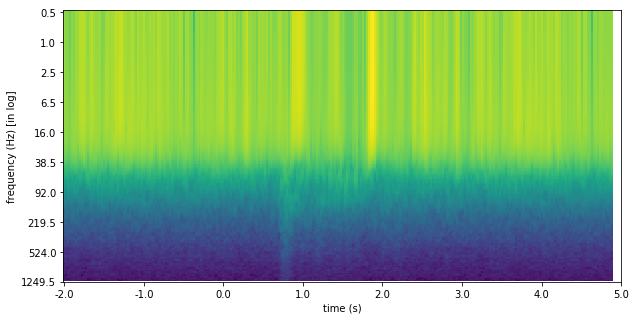

In [61]:
plt.figure(figsize=(10,5))
plt.imshow(tfdata[1,np.logspace(0,np.log10(2500),200, dtype="int")-1,:], aspect='auto')
plt.yticks(np.linspace(1,200,10), np.logspace(0,np.log10(2500),10, dtype="int")/2)
plt.xticks(np.linspace(0, 280, 8), np.linspace(-2, 5, 8))
plt.ylabel("frequency (Hz) [in log]")
plt.xlabel("time (s)")
plt.show()

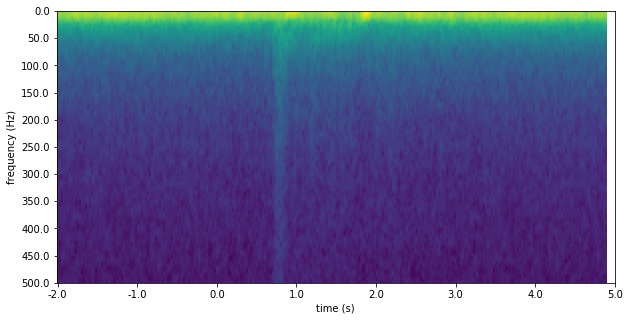

In [72]:
plt.figure(figsize=(10,5))
plt.imshow(tfdata[1,:,:], aspect='auto')
plt.yticks(np.linspace(0, 5*500, 11), np.linspace(0, 500, 11))
plt.xticks(np.linspace(0, 280, 8), np.linspace(-2, 5, 8))
plt.ylabel("frequency (Hz)")
plt.xlabel("time (s)")
plt.show()

In [130]:
def group_consecutive(a, gap=1):
    ''' group consecutive numbers in an array
        modified from https://zhuanlan.zhihu.com/p/29558169'''
    return np.split(a, np.where(np.diff(a) > gap)[0] + 1)

In [76]:
rho = 5

In [75]:
getBandRange("gamma")

(30, 150)

In [157]:
cutoff = getBandRange("gamma")
n = 3

datarise = []
for chidx in range(np.size(tfdata, 0)):
    tfcurve = np.mean(tfdata[chidx,rho*cutoff[0]:rho*cutoff[1],:],0)
    tfcurve_mu = np.mean(tfcurve[np.where(tspec<0)])
    tfcurve_shift = tfcurve - tfcurve_mu
    tfcurve_sig = np.std(tfcurve[np.where(tspec<0)])
    thresh = n*tfcurve_sig
    
    datarise_item = group_consecutive(np.where(tfcurve_shift > thresh)[0], gap=5)
    if len(datarise_item[0]) == 0:
        datarise.append([np.nan])
    else:
        points = []
        for each in datarise_item:
            x0, y0 = tspec[each[0]], tfcurve_shift[each[0]]
            xm1, ym1 = tspec[each[0]-1], tfcurve_shift[each[0]-1]
            points.append(x0 - y0 * (x0-xm1)/(y0-ym1))
        datarise.append(points)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


In [159]:
latency = np.array([])
for idx, item in enumerate(datarise):
    point = np.nan
    for each in item:
        if each > 0:
            point = each
            break
    latency = np.append(latency, point)

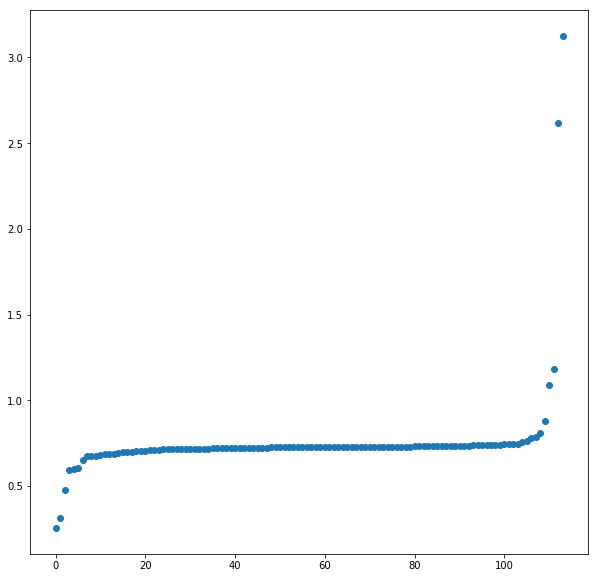

In [161]:
plt.figure(figsize=(10,10))
plt.scatter(range(125),np.sort(latency))

In [116]:
tfcurve = np.mean(tfdata[1,rho*30:rho*150,:],0)
tfcurve_mu = np.mean(tfcurve[np.where(tspec<2)])
tfcurve_shift = tfcurve - tfcurve_mu
tfcurve_sig = np.std(tfcurve[np.where(tspec<2)])
thresh = 3*tfcurve_sig

In [127]:
group_consecutive(np.where(tfcurve_shift > thresh)[0], step=5)

[array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
        147, 148, 149]),
 array([156, 160, 161, 162, 163, 164, 166, 167, 168, 169])]

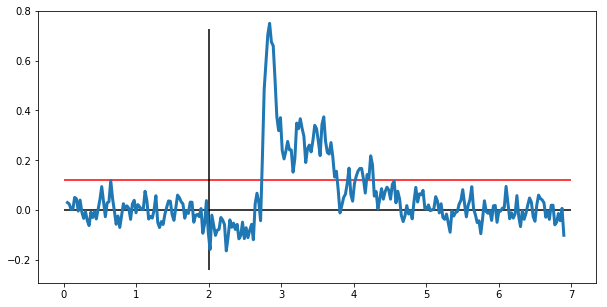

In [114]:
plt.figure(figsize=(10,5))
plt.plot(tspec, tfcurve-tfcurve_mu, linewidth=3)
plt.hlines(0,0,7)
plt.hlines(thresh, 0, 7, 'r')
plt.vlines(2, -2*thresh,6*thresh)
plt.show()
plt.close()

In [ ]:
np.where(np.mean(tfdata[1,rho*30:rho*150,:],0) > )